In [1]:
import crocoddyl as croc
import pinocchio as pin
from pinocchio.visualize import MeshcatVisualizer
import meshcat

import numpy as np
import meshcat
from os.path import join
import time
import matplotlib.pyplot as plt

from utils.plotting import plot_control_sequence, plot_state_trajectory, plot_cost, plot_convergence



In [3]:
import crocoddyl
import pinocchio as pin
import numpy as np
import example_robot_data

# 1. Load a robot model with a floating base
robot = example_robot_data.load("talos_arm")
model = robot.model
print(f"Robot model loaded. Total DoF (nv): {model.nv}")

# 2. Create the state and the actuation model
# This model understands how to apply torques to a floating-base system.
state = crocoddyl.StateMultibody(model)
actuation = crocoddyl.ActuationModelFloatingBase(state)
print(f"Actuation model created. Number of controls (nu): {actuation.nu}")
# Note: nu = nv - 6 for a floating base

# 3. Create the data structure specifically for the actuation model
# This object will store the results of the calculations.
actuation_data = actuation.createData()

# 4. Define a random state 'x' and control 'u'
# The actuation model itself doesn't use 'x', but the function signature requires it.
x = state.rand()
# 'u' is the vector of torques for the actuated joints.
u = np.random.rand(actuation.nu)

# --- Calling calc(data, x, u) directly on the ActuationModel ---
print("\n--- Calling actuation.calc() ---")

# Execute the calculation. It populates 'actuation_data'.
actuation.calc(actuation_data, x, u)

# The primary result stored in 'actuation_data' is the full torque vector 'tau'.
print(f"Control input u (size {actuation.nu}):\n", u)
print(f"\nResulting full torque vector tau (size {model.nv}):\n", actuation_data.tau)

print("\nNotice that the first 6 elements of tau are 0 (for the base),")
print("and the rest of the elements match the control input u.")


# --- Calling calcDiff(data, x, u) directly on the ActuationModel ---
print("\n--- Calling actuation.calcDiff() ---")

# Execute the derivative calculation. It populates 'actuation_data'.
# Note: calc() must be called first on the same data.
actuation.calcDiff(actuation_data, x, u)

# The results are the Jacobians of the torque vector.
print(f"Derivative of tau w.r.t. state x (dtau_dx) (shape {actuation_data.dtau_dx.shape}):")
print(actuation_data.dtau_dx)
print("\nThis is a zero matrix because torque depends on control u, not state x.")

print(f"\nDerivative of tau w.r.t. control u (dtau_du) (shape {actuation_data.dtau_du.shape}):")
print(actuation_data.dtau_du)
print("\nThis matrix maps u to tau. It has a block of zeros on top and an identity matrix below.")

Robot model loaded. Total DoF (nv): 7
Actuation model created. Number of controls (nu): 6

--- Calling actuation.calc() ---
Control input u (size 6):
 [0.17287383 0.13437412 0.86447269 0.62634764 0.08232268 0.85550344]

Resulting full torque vector tau (size 7):
 [0.         0.17287383 0.13437412 0.86447269 0.62634764 0.08232268
 0.85550344]

Notice that the first 6 elements of tau are 0 (for the base),
and the rest of the elements match the control input u.

--- Calling actuation.calcDiff() ---
Derivative of tau w.r.t. state x (dtau_dx) (shape (7, 14)):
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]

This is a zero matrix because torque depends on control u, not state x.

Derivative of tau w.r.t. control u (dtau_du) (sha

In [2]:
path_to_urdf = "h1_2_description/"
urdf_name = "h1_2_handless.urdf"

# Load the robot
model, collision_model, visual_model = pin.buildModelsFromUrdf(
    filename = join(path_to_urdf, urdf_name),
    package_dirs = path_to_urdf,
    root_joint = pin.JointModelFreeFlyer(),
)
model.armature = np.ones(model.nv) * 1e-3
data = model.createData()

In [4]:
state = croc.StateMultibody(model)
actuation = croc.ActuationModelFloatingBase(state)

In [ ]:
actuation.calcDiff

AttributeError: 'Boost.Python.function' object has no attribute '__attr__'

In [11]:
dir(state)

['Jdiff',
 'Jintegrate',
 'JintegrateTransport',
 '__class__',
 '__copy__',
 '__deepcopy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__instance_size__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'copy',
 'diff',
 'has_limits',
 'integrate',
 'lb',
 'ndx',
 'nq',
 'nv',
 'nx',
 'pinocchio',
 'rand',
 'ub',
 'zero']

In [4]:
# Get the first foot positions as references for the Baumegarte contact placement corrector
pin.framesForwardKinematics(model, data, q0)
oMleft_foot = data.oMf[left_foot_id]
oMright_foot = data.oMf[right_foot_id]
mean_height = (oMleft_foot.translation[2] + oMright_foot.translation[2]) / 2.0
# Update the initial robot position to have the feet on the ground (this is just for better visualization)
q0[2] -= mean_height
oMleft_foot.translation[2] -= mean_height
oMright_foot.translation[2] -= mean_height
viz.display(q0)

x0 = np.concatenate([q0, v0])  # Initial state
N = 100
dt = 0.02
# Define the reference trajectory to follow
pin.centerOfMass(model, data, q0, compute_subtree_coms=False)
highest = data.com[0][2]
lowest = data.com[0][2] * 0.6
mean_com = (highest + lowest) / 2.0
amplitude = (highest - lowest) / 2.0
traj = [mean_com + amplitude * np.cos(2* np.pi * t / N) for t in range(N)]

# plt.figure()
# plt.plot(traj)
# plt.show()

# Build running models
running_models = []
for t in range(N-1):
    state = croc.StateMultibody(model)
    actuation = croc.ActuationModelFloatingBase(state)
    ## Contacts
    contacts = croc.ContactModelMultiple(state, actuation.nu)
    for cid, placement in zip([right_foot_id, left_foot_id], [oMright_foot, oMleft_foot]):
        contact = croc.ContactModel6D(
            state,
            cid,
            placement,
            pin.ReferenceFrame.LOCAL_WORLD_ALIGNED,
            actuation.nu,
            np.array([200.0, 20.0])
        )
        contacts.addContact(f"{model.frames[cid]}_contact", contact)
    #### Costs ####
    costs = croc.CostModelSum(state, actuation.nu)
    ## State regularization
    xRegResidual = croc.ResidualModelState(state, x0, actuation.nu)
    xRegCost = croc.CostModelResidual(
        state,
        croc.ActivationModelWeightedQuad(np.concatenate((np.zeros(nv), np.ones(nv)))),
        xRegResidual,
    )
    if weights["x_reg"] > 0.0:
        costs.addCost("xReg", xRegCost, weights["x_reg"])
    ## Control regularization
    uRegResidual = croc.ResidualModelControl(state, actuation.nu)
    uRegCost = croc.CostModelResidual(
        state,
        croc.ActivationModelWeightedQuad(np.ones(actuation.nu)),
        uRegResidual,
    )
    if weights["u_reg"] > 0.0:
        costs.addCost("uReg", uRegCost, weights["u_reg"])
    ## Reference trajectory tracking
    comTrackResidual = croc.ResidualModelCoMPosition(state, np.array([0, 0, traj[t]]), actuation.nu)
    comTrackCost = croc.CostModelResidual(
        state,
        croc.ActivationModelWeightedQuad(np.array([0, 0, 1.0])),
        comTrackResidual,
    )
    if weights["com_track"] > 0.0:
        costs.addCost("xRef", comTrackCost, weights["com_track"])
    #### Differential Action Model ####
    dam = croc.DifferentialActionModelContactFwdDynamics(
        state,
        actuation,
        contacts,
        costs,
    )
    am = croc.IntegratedActionModelEuler(
        dam,
        dt
    )
    running_models.append(am)

# Build the terminal model
contacts = croc.ContactModelMultiple(state, actuation.nu)
for cid in [right_foot_id, left_foot_id]:
    contact = croc.ContactModel6D(
        state,
        cid,
        pin.SE3.Identity(),
        pin.ReferenceFrame.LOCAL_WORLD_ALIGNED,
        actuation.nu,
        np.array([0.0, 10.0])
    )
    contacts.addContact(f"{model.frames[cid]}_contact", contact)
## Costs
costs = croc.CostModelSum(state, actuation.nu)
## State regularization
xRegResidual = croc.ResidualModelState(state, x0, actuation.nu)
xRegCost = croc.CostModelResidual(
    state,
    croc.ActivationModelWeightedQuad(np.ones(ndx)),
    xRegResidual,
)
if weights["x_reg_term"] > 0.0:
    costs.addCost("xReg", xRegCost, weights["x_reg_term"])
## Action model
dam = croc.DifferentialActionModelContactFwdDynamics(
    state,
    actuation,
    contacts,
    costs,
)
terminal_model = croc.IntegratedActionModelEuler(
    dam,
    dt
)

In [6]:
### Define the shooting problem
problem = croc.ShootingProblem(
    x0=x0,
    runningModels=running_models,
    terminalModel=terminal_model,
)
ddp = croc.SolverFDDP(problem)
ddp.th_stop = 1e-6
ddp.setCallbacks([croc.CallbackLogger(), croc.CallbackVerbose()])

xs_init = [x0] * N
us_init = [np.zeros(model.nv - 6)] * (N - 1)

print("Starting DDP optimization...")
ddp.solve(xs_init, us_init, 100)
#ddp.solve()

Starting DDP optimization...
iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
   0  1.644e-02  0.000e+00  2.611e-02  3.204e-02  1.000e-09  1.000e-09  0.5000  9.657e-01  0.000e+00  0.000e+00  1.854e-02  2.208e-02  0.000e+00  0.000e+00
   1  1.381e-02  0.000e+00  7.238e-04  4.203e-03  1.000e-09  1.000e-09  0.5000  4.829e-01  0.000e+00  0.000e+00  2.107e-03  2.626e-03  0.000e+00  0.000e+00
   2  1.611e-02  0.000e+00  2.285e-03  3.337e-04  1.000e-09  1.000e-09  1.0000  2.414e-01  0.000e+00  0.000e+00 -2.285e-03 -2.300e-03  0.000e+00  0.000e+00
   3  1.597e-02  0.000e+00  1.150e-04  2.301e-04  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.150e-04  1.434e-04  0.000e+00  0.000e+00
   4  1.595e-02  0.000e+00  1.189e-05  2.378e-05  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  1.189e-05  1.955e-05  0.000e+00  0.000e+00
   5  1.594e-02  0.000e+00  5.962e-06 

True

iter    cost       merit      stop      |grad|      preg       dreg      step   ||ffeas||  ||gfeas||  ||hfeas||   dV-exp       dV      dPhi-exp     dPhi
  10  1.592e-02  0.000e+00  7.486e-07  1.497e-06  1.000e-09  1.000e-09  1.0000  0.000e+00  0.000e+00  0.000e+00  7.486e-07  1.349e-06  0.000e+00  0.000e+00


In [6]:
xs_sol = np.array(ddp.xs)
us_sol = np.array(ddp.us)

# Visualize the solution
for i in range(len(xs_sol)):
    viz.display(xs_sol[i, :nq])
    time.sleep(dt)


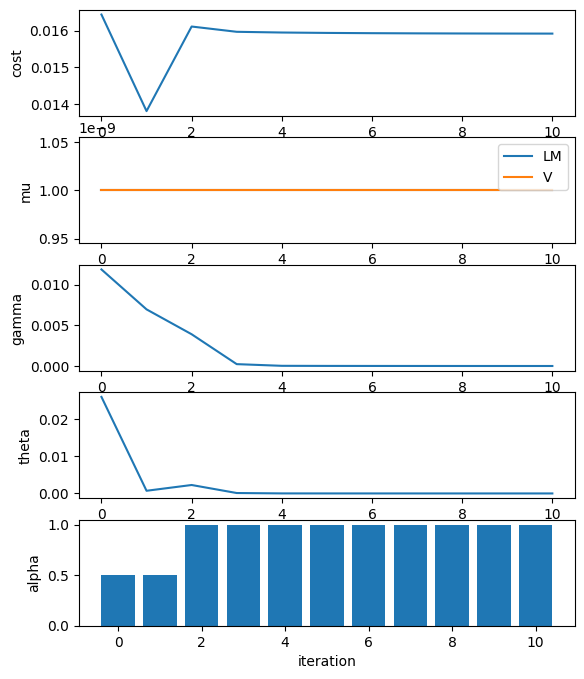

In [7]:
log = ddp.getCallbacks()[0]

croc.plotConvergence(
    log.costs,
    log.pregs,
    log.dregs,
    log.grads,
    log.stops,
    log.steps,
    figIndex=2,
    show=False,
)

## MPPI

In [5]:
ddp.us[0].shape

NameError: name 'ddp' is not defined

In [8]:
# MPPI parameters
from MPPI.mppi import MPPI, MPPILogger
from MPPI.mppi_ddp import MPPIDDP

horizon = 10 # 50 # 10       # Number of time steps in the prediction horizon
num_samples = 100    # Number of control samples
lambda_param = 1    # Temperature parameter
noise_std = np.full(21, 0.001)
n_iter = 30
# Logging
logger_mppi = MPPILogger(enable_logging=True, n_log=5)
problem = croc.ShootingProblem(
    x0=x0,
    runningModels=running_models[:horizon],
    terminalModel=terminal_model,
)

# Initial state for the unicycle: [x, y, yaw]
# x0 = robot_model.x0

print("Running MPPI solver...")
mppi_solver = MPPIDDP(running_models[0], terminal_model, horizon, num_samples, lambda_param, noise_std,
                   param_exploration=0.0, n_filt=1, logger=logger_mppi,
                   ddp_problem = problem)

# u_opt_mppi = mppi_solver.solve(x0, n_iter)
u_opt_mppi = mppi_solver.solve_receding_horizon(x0, 200)

print("\nRolling out trajectory with optimal controls...")
x_opt_mppi, mppi_final_cost = mppi_solver.rollout_trajectory(x0, u_opt_mppi)
# Store the final optimized nominal control sequence in the logger
logger_mppi.set_final_controls(u_opt_mppi)
logger_mppi.set_final_state(x_opt_mppi)

print(f"Final cost of optimal trajectory: {mppi_final_cost:.4f}")

Running MPPI solver...
Iteration 1/200, Min Cost: 0.0005, Mean Cost: 0.6339, DDP Cost: 0.0005, DDP Converged: False
Iteration 2/200, Min Cost: 0.1265, Mean Cost: 0.6912, DDP Cost: 0.1265, DDP Converged: False
Iteration 3/200, Min Cost: 0.0857, Mean Cost: 0.7478, DDP Cost: 0.0857, DDP Converged: False
Iteration 4/200, Min Cost: 0.1764, Mean Cost: 0.8091, DDP Cost: 0.1764, DDP Converged: False
Iteration 5/200, Min Cost: 0.1724, Mean Cost: 0.8774, DDP Cost: 0.1724, DDP Converged: False
Iteration 6/200, Min Cost: 0.1956, Mean Cost: 0.9488, DDP Cost: 0.1956, DDP Converged: False
Iteration 7/200, Min Cost: 0.2261, Mean Cost: 1.0284, DDP Cost: 0.2261, DDP Converged: False
Iteration 8/200, Min Cost: 0.2696, Mean Cost: 1.1229, DDP Cost: 0.2696, DDP Converged: False
Iteration 9/200, Min Cost: 0.3427, Mean Cost: 1.2478, DDP Cost: 0.3427, DDP Converged: False
Iteration 10/200, Min Cost: 0.5162, Mean Cost: 1.4268, DDP Cost: 0.5162, DDP Converged: False
Iteration 11/200, Min Cost: 1.5253, Mean Cost:

In [9]:
nu = 21
u_random = np.random.multivariate_normal(
                np.zeros(nu),
                np.diag(noise_std**2),
                size=(10,)
            )
x, cost = mppi_solver.rollout_trajectory(x0, u_random)
print(cost)

0.6403172550820994


In [10]:
# Visualize the solution
for i in range(len(x)):
    viz.display(x[i, :nq])
    time.sleep(dt)


(0.0, 10.0)

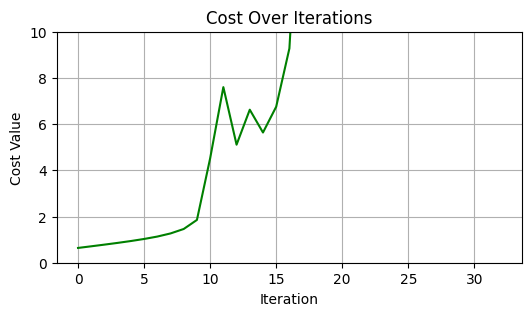

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(6, 3)) # [2]
# Plot each cost history on the same subplot
plot_cost(logger_mppi.total_cost_hist, ax=ax, color="green",  label="MPPI") 
#plt.xlim(0, 30)
plt.ylim(0, 10)